In [ ]:
!pip install ucimlrepo
# You may need to install certain dependencies
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# DATA EXPLORATION

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
all_attributes = breast_cancer_wisconsin_diagnostic.data.features # all rows
all_results = breast_cancer_wisconsin_diagnostic.data.targets # results of rows
all_results['Diagnosis'] = all_results['Diagnosis'].map({'M': 1, 'B': 0})

features_to_plot = [
    "radius1", "texture1", "perimeter1", "area1", "smoothness1",
    "compactness1", "concavity1", "concave_points1", "symmetry1", "fractal_dimension1",
    "radius2", "texture2", "perimeter2", "area2", "smoothness2",
    "compactness2", "concavity2", "concave_points2", "symmetry2", "fractal_dimension2",
    "radius3", "texture3", "perimeter3", "area3", "smoothness3",
    "compactness3", "concavity3", "concave_points3", "symmetry3", "fractal_dimension3"
]

# show features without ids, since they've been dropped
print('Attributes: \n', all_attributes)
print('Results: \n', all_results)

# visualize as grid of boxplots
cols, rows = 3, 3
per_page = rows * cols

for start in range(0, len(features_to_plot), per_page):
    subset = features_to_plot[start:start+per_page]
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = axes.flatten()
    for i, feature in enumerate(subset):
        all_attributes.boxplot(column=feature, ax=axes[i])
        axes[i].set_title(feature, fontsize=10)
        axes[i].set_ylabel("Value")
    for j in range(len(subset), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    # There are two main takeaways from these plots. First and foremost, the
    # magnitude of these features varies widely. For a an algorithm like kNN which
    # which relies heavily on euclidean distance as a measure of proximity and
    # classification, this will need to be addressed. Similarly, there are many
    # large outliers, which is not unexpected given the nature of the data wherein
    # we're often looking for larger/anamolous values. Nonetheless, these two
    # insights from the plots indicate the importance of scaling the features
    # before training the model.

In [4]:
# DATA CLEANING

# In this particular data set, it has been observed there is no missing data, so
# no imputation is needed. This was mentioned in the source of the dataset and was
# observed personally in sampls of the data. Proof:

print("Number of missing values:", all_attributes.isna().sum().sum())


Number of missing values: 0


In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np


# ALGORITHM IMPLEMENTATION

# Justification
#
# In the implementation of the algorithm, I tested 10 k-values ([1, 10]),
# over 100 trials, using 10-fold stratified sampling.
#
# After some data exploration over an extended range of k-values, it was determined that 10 k-values
# was sufficient to show the underlying trend. Similarly, 100 trials is
# sufficient to remove extreme variance, and maintains a similar pattern over
# multiple runs of the program.
#


k = 10 # Neighbours
trials = 100 # Lowers variance
average_accuracies = []
average_f1_scores = []
average_std =[]
folds = 10

for i in range(1,k+1):
  accuracies = []
  f1_scores = []
  for t in range(trials):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=t)
    for train_index, test_index in skf.split(all_attributes, all_results.values.ravel()):

      X_train, X_test = all_attributes.iloc[train_index], all_attributes.iloc[test_index]
      y_train, y_test = all_results.iloc[train_index], all_results.iloc[test_index]
      scaler = MinMaxScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
      classifier = KNeighborsClassifier(n_neighbors = i)
      classifier.fit(X_train_scaled, y_train.values.ravel())

      prediction = classifier.predict(X_test_scaled) # Generates prediction
      accuracy = accuracy_score(y_test.values.ravel(), prediction)
      f1 = f1_score(y_test.values.ravel(), prediction, average='macro')
      accuracies.append(accuracy)
      f1_scores.append(f1)
  avg_acc = np.mean(accuracies)
  std_acc = np.std(accuracies)
  avg_f1 = np.mean(f1_scores)
  average_accuracies.append(avg_acc)
  average_f1_scores.append(avg_f1)
  average_std.append(std_acc)

avg_acc = np.array(average_accuracies)
avg_f1 = np.array(average_f1_scores)
std_acc = np.array(average_std)

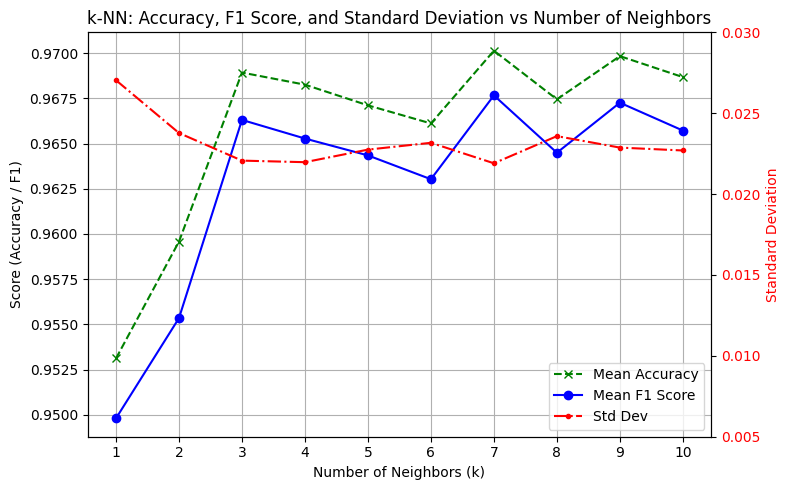

Max accuracy:  7
Max f1 score:  7
Min standard deviation:  7


In [6]:
fig, ax1 = plt.subplots(figsize=(8,5))
k_values = range(1, k+1)


# Primary axis: Accuracy and F1
ax1.plot(k_values, avg_acc, marker='x', linestyle='--', color='green', label='Mean Accuracy')
ax1.plot(k_values, avg_f1, marker='o', linestyle='-', color='blue', label='Mean F1 Score')
ax1.set_xlabel("Number of Neighbors (k)")
ax1.set_ylabel("Score (Accuracy / F1)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(k_values)
ax1.grid(True)

# Secondary axis: Standard deviation
ax2 = ax1.twinx()
ax2.plot(k_values, std_acc, marker='.', linestyle='-.', color='red', label='Std Dev')
ax2.set_ylabel("Standard Deviation", color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0.005, 0.03)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower right')

plt.title("k-NN: Accuracy, F1 Score, and Standard Deviation vs Number of Neighbors")
fig.tight_layout()
plt.show()

print('Max accuracy: ', avg_acc.argmax()+1)
print('Max f1 score: ', avg_f1.argmax() +1)
print('Min standard deviation: ', std_acc.argmin()+1)

# **Take aways:**
The KNN evaluation demonstrated a clear, stable performance trend across different neighbor counts. Using 10-fold stratified cross-validation repeated over 100 randomized trials reduced variance and gave a reliable idea of model behaviour. Before modeling, the dataset's 569 samples with 30 numeric features was scaled with a Min-Max transformer and the target labels were encoded to ensure that all features contributed equally to the Euclidean distance used by KNN.


Testing k values from 1 through 10 showed that accuracy and macro-averaged F1 scores were consistently high, with only minor fluctuations as k increased. The repeated sampling confirmed that 100 trials were enough to smooth out run-to-run noise. the standard deviation of accuracy stayed low which gave confidence in the method’s stability.


It's important to note the assumptions and limits of this approach. KNN’s performance is tied to the choice of distance metric, Euclidean can worse in high dimensions if irrelevant features are present. Results are specific to this dataset’s structure and may not generalize without careful feature
selection.


For future work, it would be worthwhile to explore alternative distance metrics, apply distance-weighted voting, or compare KNN’s results against other classifiers to verify its validity.


Overall, the experiment validates that a modest range of k values is sufficient to capture the relationship in the dataset, and that the chosen cross-validation and repeatedtrial strategy provides dependable metrics for both accuracy and F1 performance. These findings suggest that KNN can serve as a robust baseline model for similar diagnostic tasks.


# **Conclusion:**
Through the process of processing the data, exploring its features, training the model and testing against various values of K,  the experiemnt was able to determine a likely best hyperparameter for K. Multiple different metrics were used to evaluate the different k values, including F score, accuracy, and standard deviation. To assure consistency and reliability of the results, each value of K was calculated 100 times with fresh partitions and model training. In the end, thanks to its minimal standard deviation and maximal F score and accuracy, a k value of 7 was seen to be the best.